pip the requirement.txt in a conda env with python 3.12

DATA preparation

In [1]:
import pandas as pd
import os

path = r'C:\Users\HEARTTLESSS\Desktop\Purdue\Courses\570\IMPLEMENTATION\Extended_ViLT\data'
train_file = os.path.join(path, 'combined_train.csv')
val_file = os.path.join(path, 'combined_val.csv')
test_file = os.path.join(path, 'combined_test.csv')

train_df = pd.read_csv(train_file)
val_df = pd.read_csv(val_file)
test_df = pd.read_csv(test_file)

# print(train_df.head)


In [2]:
import requests
from bs4 import BeautifulSoup as bs
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

# Avoid 403 error
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'
}

path = r'C:\Users\HEARTTLESSS\Desktop\Purdue\Courses\570\IMPLEMENTATION\Extended_ViLT\data'

def download_image(row):
    img_url = row['Geograph URI']
    img_filename = row['filename']  # 'filename' column

    outpath = os.path.join(path, img_filename)
    # Check if the file already exists before downloading
    if os.path.exists(outpath):
        # File already exists, skip downloading
        return True 
    try:
        # Fetch the webpage content
        response = requests.get(img_url, headers=headers)
        response.raise_for_status()
        
        # Parse HTML and find images
        soup = bs(response.content, 'html.parser')
        images = soup.findAll("img")

        for image in images:
            src = image.get("src")
            if src and src.lower().startswith("http") and src.endswith(img_filename):
                os.makedirs(os.path.dirname(outpath), exist_ok=True)

                # Download and save 
                img_data = requests.get(src, headers=headers)
                img_data.raise_for_status()
                with open(outpath, 'wb') as file:
                    file.write(img_data.content)

                return True  # successful

    except Exception as e:
        print(f"Error downloading {img_url}: {e}")
    return False  # failed

def download_dataframe_img(dataframe):
    img_count = 0
    total = len(dataframe)
    # !!Use a thread pool to download images in parallel
    with ThreadPoolExecutor(max_workers=20) as executor:
        futures = [executor.submit(download_image, row) for index, row in dataframe.iterrows()]
        for future in as_completed(futures):
            if future.result():
                img_count += 1
                if img_count % 10 == 0:
                    print(f'Downloaded {img_count}/{total} images')
            else:
                pass  # Download failed
    print(f'Finished downloading. Successfully downloaded {img_count}/{total} images')

download_dataframe_img(train_df)
download_dataframe_img(val_df)
download_dataframe_img(test_df)


Downloaded 10/8000 images
Downloaded 20/8000 images
Downloaded 30/8000 images
Downloaded 40/8000 images
Downloaded 50/8000 images
Downloaded 60/8000 images
Downloaded 70/8000 images
Downloaded 80/8000 images
Downloaded 90/8000 images
Downloaded 100/8000 images
Downloaded 110/8000 images
Downloaded 120/8000 images
Downloaded 130/8000 images
Downloaded 140/8000 images
Downloaded 150/8000 images
Downloaded 160/8000 images
Downloaded 170/8000 images
Downloaded 180/8000 images
Downloaded 190/8000 images
Downloaded 200/8000 images
Downloaded 210/8000 images
Downloaded 220/8000 images
Downloaded 230/8000 images
Downloaded 240/8000 images
Downloaded 250/8000 images
Downloaded 260/8000 images
Downloaded 270/8000 images
Downloaded 280/8000 images
Downloaded 290/8000 images
Downloaded 300/8000 images
Downloaded 310/8000 images
Downloaded 320/8000 images
Downloaded 330/8000 images
Downloaded 340/8000 images
Downloaded 350/8000 images
Downloaded 360/8000 images
Downloaded 370/8000 images
Downloaded

Load pretrained ViLT model

In [3]:
# Load pretrained ViLT model
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
print(torch.__version__)
# print(model)


2.5.1+cu121


In [5]:
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.transforms import Resize
import torchvision
import numpy as np

class ViltDataset(Dataset):
  def __init__(self, dataframes):
    self.base_path = r'C:\Users\HEARTTLESSS\Desktop\Purdue\Courses\570\IMPLEMENTATION\Extended_ViLT\data'
    self.img_paths = dataframes['filename']
    self.comments = dataframes['clean_comments']
    self.resize = Resize((384, 512))
    self.labels = dataframes['scenic']

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    img = self.resize(read_image(os.path.join(self.base_path, img_path), mode=torchvision.io.ImageReadMode.RGB))
    comment = self.comments[idx]
    encoding = processor(img, comment, return_tensors='pt', padding='max_length', truncation=True)

    #label for MSE loss
    label = torch.nn.functional.one_hot(torch.tensor(self.labels[idx]), num_classes=2)
    
    #label for CrossEntropyLoss
    # label = int(self.labels[idx])

    return [encoding, label]
  
  

In [6]:
# create dataloaders
training_data = ViltDataset(train_df[:])
test_data = ViltDataset(test_df[:])
val_data = ViltDataset(val_df[:])

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=True)

In [ ]:
## THIS is only for testing from the term paper, no need to run, just here for demonstration!
class ScenicClassifier_CrossEntropy(torch.nn.Module):
    def __init__(self, enc_features: int):
        super().__init__()
        self.embedding = model.vilt
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(enc_features, 64, bias=False),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(64, 32, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 2, bias=False)
        )

    def forward(self, encodings):
        embeds = self.embedding(**encodings)['pooler_output']
        logits = self.classifier(embeds)
        return logits
    
class ScenicClassifier_BCE(torch.nn.Module):
    def __init__(self, enc_features: int):
        super().__init__()
        self.embedding = model.vilt
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(enc_features, 64, bias=False),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(64, 32, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1, bias=False)  # Output size changed to 1
        )

    def forward(self, encodings):
        embeds = self.embedding(**encodings)['pooler_output']
        logits = self.classifier(embeds)
        return logits

device='cuda:0'

classifier = ScenicClassifier_BCE(768)
classifier.to(device)

# criterion = torch.nn.MSELoss()
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCEWithLogitsLoss()

# optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.8)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

## Train with different configurations

In [ ]:
## THIS is only for testing from the term paper, no need to run, just here for demonstration!
classifier.train()
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (encodings, labels) in enumerate(train_dataloader, 0):
        for key in encodings.keys():
            encodings[key] = encodings[key].squeeze(1).to(device)
        
        labels = labels.to(device, dtype=torch.float).unsqueeze(1)

        optimizer.zero_grad()
        outputs = classifier(encodings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 10 == 9:
            print(f'[{epoch+1}, {i+1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0



[1,     9] loss: 0.616
[1,    19] loss: 0.695
[1,    29] loss: 0.699
[1,    39] loss: 0.685
[1,    49] loss: 0.701
[1,    59] loss: 0.696
[1,    69] loss: 0.693
[1,    79] loss: 0.699
[1,    89] loss: 0.695
[1,    99] loss: 0.694
[1,   109] loss: 0.689
[1,   119] loss: 0.700
[1,   129] loss: 0.695
[1,   139] loss: 0.693
[1,   149] loss: 0.695
[1,   159] loss: 0.694
[1,   169] loss: 0.696
[1,   179] loss: 0.694
[1,   189] loss: 0.693
[1,   199] loss: 0.691
[1,   209] loss: 0.696
[1,   219] loss: 0.693
[1,   229] loss: 0.696
[1,   239] loss: 0.695
[1,   249] loss: 0.693
[2,     9] loss: 0.624
[2,    19] loss: 0.693
[2,    29] loss: 0.692
[2,    39] loss: 0.692
[2,    49] loss: 0.697
[2,    59] loss: 0.694
[2,    69] loss: 0.694
[2,    79] loss: 0.693
[2,    89] loss: 0.694
[2,    99] loss: 0.693
[2,   109] loss: 0.692
[2,   119] loss: 0.693
[2,   129] loss: 0.692
[2,   139] loss: 0.694
[2,   149] loss: 0.694
[2,   159] loss: 0.692
[2,   169] loss: 0.694
[2,   179] loss: 0.694
[2,   189] 

KeyboardInterrupt: 

In [ ]:
## THIS is only for testing from the term paper, no need to run, just here for demonstration!
import torch
import random
import numpy as np

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
## network
class ScenicClassifier(torch.nn.Module):
    def __init__(self, enc_features: int):
        super().__init__()
        self.embedding = model.vilt
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(enc_features, 64, bias=False),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(64, 32, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 2, bias=False)
        )

    def forward(self, encodings):
        embeds = self.embedding(**encodings)['pooler_output']
        logits = self.classifier(embeds)
        return logits

##
device = 'cuda:0'
classifier = ScenicClassifier(768)
classifier.to(device)

criterion = torch.nn.MSELoss()
criterion.to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

classifier.embedding.train()
num_epochs = 5
##

## training
classifier.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        encodings, labels = data
        
        encodings = {k: v.to(device) for k, v in encodings.items()}
        labels = labels.to(device).float()

        for key in encodings.keys():
            encodings[key] = torch.squeeze(encodings[key], 1)

        optimizer.zero_grad()
        outputs = classifier(encodings)
        loss = criterion(outputs, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

        if (i+1) % 10 == 9:
            print(f'[{epoch+1}, {i+1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0



[1,     9] loss: 0.312
[1,    19] loss: 0.283
[1,    29] loss: 0.268
[1,    39] loss: 0.263
[1,    49] loss: 0.267
[1,    59] loss: 0.264
[1,    69] loss: 0.265
[1,    79] loss: 0.259
[1,    89] loss: 0.263
[1,    99] loss: 0.268
[1,   109] loss: 0.266
[1,   119] loss: 0.263
[1,   129] loss: 0.265
[1,   139] loss: 0.257
[1,   149] loss: 0.263
[1,   159] loss: 0.260
[1,   169] loss: 0.255
[1,   179] loss: 0.265
[1,   189] loss: 0.257
[1,   199] loss: 0.258
[1,   209] loss: 0.260
[1,   219] loss: 0.249
[1,   229] loss: 0.261
[1,   239] loss: 0.259
[1,   249] loss: 0.254
[2,     9] loss: 0.229
[2,    19] loss: 0.254


KeyboardInterrupt: 

Successful version, you can train the model again by running this part of the code, or just use the model provided I uploaded

In [ ]:

import torch
import random
import numpy as np

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
## network
class ScenicClassifier(torch.nn.Module):
    def __init__(self, enc_features: int):
        super().__init__()
        self.embedding = model.vilt
 
        self.classifier = torch.nn.Sequential(
        torch.nn.Linear(enc_features, 32, bias=False),
        torch.nn.Linear(32, 2, bias=False),
        )
        

    def forward(self, encodings):
        embeds = self.embedding(**encodings)['pooler_output']
        logits = self.classifier(embeds)
        return logits

##
device = 'cuda:0'
classifier = ScenicClassifier(768)
classifier.to(device)

criterion = torch.nn.MSELoss()
criterion.to(device)
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.8)

classifier.embedding.train()
num_epochs = 5
##

##training
classifier.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        encodings, labels = data

        encodings = {k: v.to(device) for k, v in encodings.items()}
        labels = labels.to(device).float()

        for key in encodings.keys():
            encodings[key] = torch.squeeze(encodings[key], 1)

        optimizer.zero_grad()
        outputs = classifier(encodings)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

        if (i+1) % 10 == 9:
            print(f'[{epoch+1}, {i+1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0



[1,     9] loss: 0.469
[1,    19] loss: 0.385
[1,    29] loss: 0.276
[1,    39] loss: 0.233
[1,    49] loss: 0.226
[1,    59] loss: 0.210
[1,    69] loss: 0.191
[1,    79] loss: 0.187
[1,    89] loss: 0.170
[1,    99] loss: 0.178
[1,   109] loss: 0.151
[1,   119] loss: 0.150
[1,   129] loss: 0.141
[1,   139] loss: 0.125
[1,   149] loss: 0.114
[1,   159] loss: 0.112
[1,   169] loss: 0.124
[1,   179] loss: 0.114
[1,   189] loss: 0.117
[1,   199] loss: 0.124
[1,   209] loss: 0.127
[1,   219] loss: 0.108
[1,   229] loss: 0.104
[1,   239] loss: 0.095
[1,   249] loss: 0.123
[2,     9] loss: 0.095
[2,    19] loss: 0.122
[2,    29] loss: 0.102
[2,    39] loss: 0.112
[2,    49] loss: 0.092
[2,    59] loss: 0.080
[2,    69] loss: 0.095
[2,    79] loss: 0.092
[2,    89] loss: 0.090
[2,    99] loss: 0.100
[2,   109] loss: 0.086
[2,   119] loss: 0.088
[2,   129] loss: 0.094
[2,   139] loss: 0.084
[2,   149] loss: 0.070
[2,   159] loss: 0.083
[2,   169] loss: 0.104
[2,   179] loss: 0.081
[2,   189] 

In [ ]:
#save the model
model_path = r'C:\Users\HEARTTLESSS\Desktop\Purdue\Courses\570\IMPLEMENTATION\Extended_ViLT\model.pt'
torch.save(classifier.state_dict(), model_path)

## Test the result

In [12]:
from sklearn.metrics import f1_score

def f1_score_eval(dataloader, dataname):
  correct = 0
  total = 0
  predicts = []
  groundtruth = []
  with torch.no_grad():
    for testdata in dataloader:
      encodings, labels = testdata
      encodings = encodings.to(device)
      for key in encodings.keys():
        encodings[key] = torch.squeeze(encodings[key], 1)
      output = classifier(encodings)
      _, predicted = torch.max(output.data, 1)
      predicts.append(predicted.to('cpu'))
      total+= labels.size(0)
      groundtruth.append(torch.argmax(labels.to('cpu'), 1))
      correct+=(predicted.to('cpu')==torch.argmax(labels.to('cpu'), 1)).sum().item()

  print(f'Accuracy of the network on {dataname} images : {100*correct//total}%')


In [13]:
f1_score_eval(val_dataloader, 'validation')
f1_score_eval(test_dataloader, 'test')


Accuracy of the network on validation images : 92%
Accuracy of the network on test images : 92%


TEST the model with actual image and human language as input

In [14]:
import torch
model_path = r'C:\Users\HEARTTLESSS\Desktop\Purdue\Courses\570\IMPLEMENTATION\Extended_ViLT\model.pt'
classifier = ScenicClassifier(768)
classifier.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
classifier.eval()

C:\Users\HEARTTLESSS\AppData\Local\Temp\ipykernel_265924\482033938.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(model_path, map_

ScenicClassifier(
  (embedding): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, 

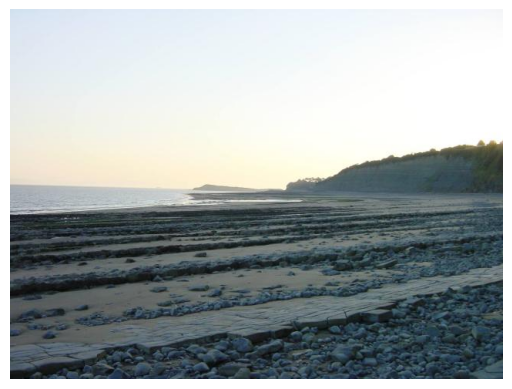

Predicted label: scenic


In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


# !!TEST image path and the input text
image_path = r'C:\Users\HEARTTLESSS\Desktop\Purdue\Courses\570\IMPLEMENTATION\Extended_ViLT\data\photos\00\11\001197_c8ab9cf7.jpg'
comment = 'looks like a seashore'

img_resize = transforms.Resize((384, 512))
label = ['not scenic', 'scenic']

img = Image.open(image_path).convert('RGB')


# Display
plt.imshow(img)
plt.axis('off')
plt.show()

encoding = processor(img, comment, return_tensors='pt', padding='max_length', truncation=True)

# Move tensors to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier.to(device)
encoding = {key: value.to(device) for key, value in encoding.items()}

# Get the prediction from the classifier
classifier.eval()
with torch.no_grad():
    predict = classifier(encoding)

predicted_label = label[torch.argmax(torch.squeeze(predict))]
print(f'Predicted label: {predicted_label}')
